# Dunnhumby data
### BASE (Papermill) >> Analysis of cannibalisation during PROMOTIONAL periods using Causal Impact (per store)



* Read the department/store data
* Read the calculated availability data or calculate it on demand
* Compare PROMO sales vs NON PROMO given the availabily
* Find the products that change their average sales
* Pick a pair of products and try the sales weighted distance analysis
* Saves the pairs in 'sku_pair_analysis'

This notebook comes from the experiments in `CFAV_simulate_cannibalisation_CausalImpact.ipynb`


Updates:

* 02.02.2021 - First attempt to out it all together
* 03.02.2021 - Stop the notebook if no cannibals found

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
from causalimpact import CausalImpact
import promotional_helpers as promies
from statsmodels.tsa.seasonal import STL

#plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

# inliners
fcn_compare = lambda a,b: abs(a-b)/max(a,b)
fcn_compare_snap_vs_regular = lambda snap,reg: snap/reg
mapper_family_to_category = fhelp.dunnhumby_get_map_dept_to_cat()

In [2]:
dataFolder = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/Dunnhumby')
xlsx_path = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/Dunnhumby')
graphsFolder = fhelp.fullfile(dataFolder, 'graphs_cannibalisation')

In [3]:
filename = os.path.join(dataFolder, 'store_info', 'stores.pickle')
df_store_info = fhelp.readPickleFile(filename)
df_store_info.sort_values(by='AVG_WEEKLY_BASKETS', ascending=False, inplace=True)

max_stores = 5
df_store_info.sort_values(by='AVG_WEEKLY_BASKETS', ascending=False, inplace=True)
# df_store_info = df_store_info.loc[0:max_stores, :]
df_store_info = df_store_info.head(max_stores)
df_store_info

,store_nbr,STORE_NAME,city,state_id,MSA_CODE,type,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,cluster,store_id
1,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54052.519231,1,OH_2277_UPSCALE_1
57,24991,HYDE PARK,CINCINNATI,OH,17140,UPSCALE,1859.0,77730,50618.993590,1,OH_24991_UPSCALE_1
36,25027,CINCINNATI,CINCINNATI,OH,17140,MAINSTREAM,NaN,62656,43892.923077,1,OH_25027_MAINSTREAM_1
45,21237,LEBANON,LEBANON,OH,17140,MAINSTREAM,NaN,86517,38465.128205,1,OH_21237_MAINSTREAM_1
12,623,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,46930,36740.692308,1,TX_623_MAINSTREAM_1


In [4]:
filename = os.path.join(dataFolder, 'store_info', 'stores.pickle')
df_store_info = fhelp.readPickleFile(filename)

mapper_store_id = dict(zip(df_store_info['store_nbr'],df_store_info['store_id']))
mapper_store_name_to_id = dict(zip(df_store_info['store_id'],df_store_info['store_nbr']))

In [5]:
# Save the plots
save_all_cannibals = True

store_name = 'OH_8041_MAINSTREAM_1'
dept_id = 'PRETZELS'

# variables that pertain to the new code
min_overlapping_days_regular=2
min_overlapping_days_promo=1

# Potential cannibals
# This threshold is used to detect uplifters based on the difference in average sales
sales_threshold = 1/3
# min AVG sales to be considered
min_avg_sales = 5


# This is the minimum bump between regular and promo
# and promo back to regular *0.25
min_diff_in_units_from_reg_to_promo = 10

# when analysing the SKUs
min_promo_days=1
min_regular_days=2

# values for the CI analysis
min_ratio_change = 0.4
do_exclude_promos_SKU_B = True
# This flag is pretty good for debugging/development
be_verbose=False



# LOESS - weekly
period_in_days = 2

# If true, use the sales without the weekly pattern
do_decomposition = False


# This threshold is used to detect the reduction in sales that one uplifter causes
cannibalisation_threshold = 1/3

# min days/times that both products overlap during the promotions of the cannibal
min_snap_days = 1

# N/A
#price_threshold = 2

#### Read the store level data

In [6]:
# Read departement sales for the current store
category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, category_id, dept_id, 'store_sales')
filename = os.path.join(foldername, f'{store_name}.pickle')
df_store = fhelp.readPickleFile(filename)

sales_vars = [iVar for iVar in df_store.columns if 'sales-' in iVar]
promotion_vars = [iVar for iVar in df_store.columns if 'promotion_flag-' in iVar]

df_store.head(2)

,date,weekdays,sales-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,sales-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,sales-PRETZELS_1111009507-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_1111009507-OH_8041_MAINSTREAM_1,sales-PRETZELS_2840002333-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_2840002333-OH_8041_MAINSTREAM_1,...,promotion_flag-PRETZELS_7110410470-OH_8041_MAINSTREAM_1,sales-PRETZELS_7110410471-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7110410471-OH_8041_MAINSTREAM_1,sales-PRETZELS_7797502248-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7797502248-OH_8041_MAINSTREAM_1,sales-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,sales-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,total_units
0,2009-01-14,Wednesday,44,False,56,False,23,False,10,False,...,True,2.0,True,11,False,19.0,False,16.0,False,240.0
1,2009-01-21,Wednesday,55,False,60,False,22,False,8,False,...,True,1.0,True,5,False,20.0,False,14.0,False,247.0


In [7]:
df_store[promotion_vars].sum()

promotion_flag-PRETZELS_1111009477-OH_8041_MAINSTREAM_1    10
promotion_flag-PRETZELS_1111009497-OH_8041_MAINSTREAM_1    12
promotion_flag-PRETZELS_1111009507-OH_8041_MAINSTREAM_1    12
promotion_flag-PRETZELS_2840002333-OH_8041_MAINSTREAM_1     9
promotion_flag-PRETZELS_2840004768-OH_8041_MAINSTREAM_1     8
promotion_flag-PRETZELS_2840004770-OH_8041_MAINSTREAM_1     8
promotion_flag-PRETZELS_7027312504-OH_8041_MAINSTREAM_1    89
promotion_flag-PRETZELS_7027316204-OH_8041_MAINSTREAM_1    85
promotion_flag-PRETZELS_7027316404-OH_8041_MAINSTREAM_1    85
promotion_flag-PRETZELS_7110410455-OH_8041_MAINSTREAM_1    20
promotion_flag-PRETZELS_7110410470-OH_8041_MAINSTREAM_1    27
promotion_flag-PRETZELS_7110410471-OH_8041_MAINSTREAM_1    25
promotion_flag-PRETZELS_7797502248-OH_8041_MAINSTREAM_1    22
promotion_flag-PRETZELS_7797508004-OH_8041_MAINSTREAM_1    40
promotion_flag-PRETZELS_7797508006-OH_8041_MAINSTREAM_1    39
dtype: int64

#### Add weather data

#### Add the trend of the department sales

In [8]:
sales_decomposition_LOESS = STL(df_store['total_units'], period=period_in_days).fit()
df_store['total_units_trend'] = sales_decomposition_LOESS.trend
df_store.head(2)

,date,weekdays,sales-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,sales-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,sales-PRETZELS_1111009507-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_1111009507-OH_8041_MAINSTREAM_1,sales-PRETZELS_2840002333-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_2840002333-OH_8041_MAINSTREAM_1,...,sales-PRETZELS_7110410471-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7110410471-OH_8041_MAINSTREAM_1,sales-PRETZELS_7797502248-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7797502248-OH_8041_MAINSTREAM_1,sales-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,sales-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,promotion_flag-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,total_units,total_units_trend
0,2009-01-14,Wednesday,44,False,56,False,23,False,10,False,...,2.0,True,11,False,19.0,False,16.0,False,240.0,253.222184
1,2009-01-21,Wednesday,55,False,60,False,22,False,8,False,...,1.0,True,5,False,20.0,False,14.0,False,247.0,234.541397


In [9]:
results_folder = 'CausalImpactResults'

category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, results_folder, category_id, dept_id)
fhelp.makeFolder(foldername)
filename = os.path.join(foldername, f'{dept_id}-{store_name}.pickle')

#### Exclude the holiday periods from the analysis
Include it in the skus's heartbeat in the analysis below

In [10]:
begin_slot = ['2009-12-23', '2010-12-22', '2011-12-22']
end_slot = ['2010-01-06', '2011-01-05', '2012-01-04']

idx_Xmas = np.zeros(df_store.shape[0], dtype=bool)

idx_slot = 0
for idx_slot in range(0, len(end_slot)):
    preXmas  = df_store.date >= begin_slot[idx_slot]
    postXmas = df_store.date <  end_slot[idx_slot]
    idx_Xmas |= (preXmas & postXmas).values
    
# at the moment only Xmas
idx_holiday_to_exclude = idx_Xmas

#### Read the store level sales decomposition

We probably should not decompose the weekly aggregation

Generate the file if required
- (sales)
- heartbeat
- trend
- seasonal 
- residual

In [11]:
# Sales decomposition - on demand
folderDecomposition = os.path.join(os.path.expanduser(dataFolder), 'sku_decomposition', category_id, dept_id)
filename = os.path.join(folderDecomposition, f'{store_name}.pickle')

if os.path.exists(filename):
    df_components = fhelp.readPickleFile(filename)
else:
    decomposed_skus = []

    # Season-Trend decomposition using LOESS
    for idx_sku, sku_name in enumerate(sales_vars):

        item_id = sku_name.split('-')[1]

        current_sales = df_store[sku_name]

        df_decomposition = fhelp.decompose_signal(current_sales, \
            period_in_days=period_in_days, minimum_heartbeat=0.85)

        rename_map = {iCol: f'{iCol}-{item_id}-{store_name}' for iCol in df_decomposition.columns}
        decomposed_skus.append(df_decomposition.rename(columns=rename_map))

    df_components = pd.concat(decomposed_skus, axis=1)

    df_components['date'] = df_store.date
    df_components['weekdays'] = df_store.weekdays

    fhelp.makeFolder(folderDecomposition)
    fhelp.toPickleFile(df_components, filename)
    print(f'Saving {filename}...')
    
df_components.head(3)

,heartbeat_flag-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,trend-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,seasonal-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,residual-PRETZELS_1111009477-OH_8041_MAINSTREAM_1,heartbeat_flag-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,trend-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,seasonal-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,residual-PRETZELS_1111009497-OH_8041_MAINSTREAM_1,heartbeat_flag-PRETZELS_1111009507-OH_8041_MAINSTREAM_1,trend-PRETZELS_1111009507-OH_8041_MAINSTREAM_1,...,heartbeat_flag-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,trend-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,seasonal-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,residual-PRETZELS_7797508004-OH_8041_MAINSTREAM_1,heartbeat_flag-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,trend-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,seasonal-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,residual-PRETZELS_7797508006-OH_8041_MAINSTREAM_1,date,weekdays
0,True,50.391680,-6.391680,0.0,True,61.705223,-5.705223,0.0,True,24.216068,...,True,20.424283,-1.424283,0.0,True,16.722862,-0.722862,0.0,2009-01-14,Wednesday
1,True,49.400509,5.599491,0.0,True,55.059407,4.940593,0.0,True,20.902785,...,True,18.722817,1.277183,0.0,True,13.196005,0.803995,0.0,2009-01-21,Wednesday
2,True,45.809051,-4.809051,0.0,True,32.176269,-4.176269,0.0,True,15.977624,...,True,18.131225,-1.131225,0.0,True,7.883414,-0.883414,0.0,2009-01-28,Wednesday


## Compare PROMOS sales vs NON PROMOS given the availabily (comparing windows of non-promos/promos)

Given the inferred availability of the SKU, calculate the following parameters for SNAP and regular periods: average sales and the standard deviation, the median and the number of days within each category.

```python
{'num_promo_slots': 2,
 'avg_promo_sales': 55.51020408163265,
 'avg_regular_sales': 41.74285714285714,
 'difference_averages_promo_to_regular': 13.76734693877551,
 'cum_difference_sales_promo_to_regular': -202.0,
 'slot_promo_avg_sales': array([56., 52.]),
 'slot_regular_avg_sales': array([37.38461538, 42.73684211]),
 'availability_value_sku_A': 0.986784140969163}
```


Then we simply select the uplifters as those SKUs that during SNAP periods have sales greater than:

'median_snap_sales'>=('median_regular_sales'*(1+sales_threshold))

### Comparison only valid if sales larger than zero
idx_B = (df_snap_stats['median_snap_sales']>0) & (df_snap_stats['median_regular_sales']>0)


### Meaning of uplifters and downlifters

Uplifters are SKU that simply sell more when on promotion. Downlifters here are a bit of a special case as when they are on promo they sell less. The promos are sku-level, unlike SNAP or NATIONAL events.

In [12]:
folderPromoStats = os.path.join(os.path.expanduser(dataFolder), 'sku_promo_slot_analysis', category_id, dept_id)
filename = os.path.join(folderPromoStats, f'{store_name}.pickle')
if os.path.exists(filename):
    df_snap_stats = fhelp.readPickleFile(filename)
else:
    # List of products
    sku_analysis = []
    sku_index = []

    for sku_A in sales_vars:
        # Get the taxonomy
        _, dept_id_A, sku_id, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_A)
        state_name = store_name.split('_')[0]

        sku_A_behaviour = promies.compare_promo_regular_sales(df_store, df_components, sku_A, \
            idx_holiday_to_exclude, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

        if sku_A_behaviour != []:
            #sku_analysis.append(sku_A_behaviour)
            sku_analysis.extend(sku_A_behaviour)
            sku_index.append(sku_A)
        
    # Stick the dicts into a DF
    df_snap_stats = pd.DataFrame(sku_analysis)
    df_snap_stats.index = sku_index
    # clean the empty dictionaries
    idx_nonsense = df_snap_stats.num_promo_slots.isna() | (df_snap_stats.num_promo_slots < 1)
    df_snap_stats = df_snap_stats[~idx_nonsense].copy()

    # for backwards compatibility
    df_snap_stats['mu_difference'] = df_snap_stats['difference_averages_promo_to_regular']
    # Add a small offset to avoid 0-divisions
    df_snap_stats['mu_delta'] = df_snap_stats[['avg_promo_sales', 'avg_regular_sales']].apply(lambda snap_reg: (snap_reg[0]+0.01)/(snap_reg[1]+0.01), axis=1)
    
    # save the file
    df_snap_stats.sort_values(by=['mu_delta'], ascending=False, inplace=True)
    
    fhelp.makeFolder(folderPromoStats)
    fhelp.toPickleFile(df_snap_stats, filename)

In [13]:
df_snap_stats.head(3)

,num_promo_slots,avg_promo_sales,avg_regular_sales,promo_days,regular_days,difference_averages_promo_to_regular,cum_difference_sales_promo_to_regular,slot_promo_avg_sales,slot_regular_avg_sales,availability_value_sku_A,mu_difference,mu_delta
sales-PRETZELS_7110410471-OH_8041_MAINSTREAM_1,5,2.937500,1.457447,16.0,94.0,1.480053,-90.0,"[1.0, 1.5, 1.5, 1.3333333333333333, 5.5]","[1.0, 0.0, 0.5714285714285714, 2.0, 1.56578947...",0.705128,1.480053,2.008591
sales-PRETZELS_7797502248-OH_8041_MAINSTREAM_1,8,15.227273,7.903226,22.0,124.0,7.324047,-645.0,"[43.666666666666664, 8.0, 15.0, 9.0, 12.5, 11....","[5.615384615384615, 7.5, 8.842105263157896, 10...",0.961538,7.324047,1.925545
sales-PRETZELS_7110410455-OH_8041_MAINSTREAM_1,5,5.150000,3.107843,20.0,102.0,2.042157,-214.0,"[2.0, 2.8, 6.25, 5.0, 7.0]","[1.9166666666666667, 0.0, 2.625, 4.0, 3.381578...",0.891026,2.042157,1.654990


#### Uplifters

In [14]:
# A bit of work on the uplifters
# Snap sales greater than the sales + threshold
idx_A = df_snap_stats['mu_delta']>=(1+sales_threshold)

# Comparison only valid if they are not zero sales
idx_B = (df_snap_stats['avg_promo_sales']>min_avg_sales) & (df_snap_stats['avg_regular_sales']>min_avg_sales)
df_snap_stats['uplift_in_median'] = (idx_A & idx_B)

# Get two groups: potential cannibals (and haloers) and victims
df_snap_uplifters = df_snap_stats[df_snap_stats['uplift_in_median']].copy()

In [15]:
num_uplifters = df_snap_uplifters.shape[0] 
valid_uplifters = num_uplifters > 0
df_snap_uplifters.sort_values(by=['mu_delta', 'mu_difference'], ascending=False, inplace=True)
#fhelp.to_random_excel_file(df_snap_uplifters, writeIndex=True)

if df_snap_uplifters.empty:
    print('No potential cannibals found')
else:
    df_snap_uplifters.head(3)


#### Find connections between cannibals and victims during PROMOTIONAL periods



Up to here, we have demonstrated that there are uplifters. Now let's look for a connection between every uplifter and the rest of SKUs.sales_vars

We are using Causal Impact to analyse SKUs.category_id, dept_id)

In [16]:
folderCausalImpactResults = os.path.join(dataFolder, 'CausalImpactResults', category_id, dept_id)
fhelp.makeFolder(folderCausalImpactResults)

folderCausalImpactResults_xlsx = os.path.join(dataFolder, 'CausalImpactResults', category_id, dept_id, 'xlsx')
fhelp.makeFolder(folderCausalImpactResults_xlsx)


filenameCI = os.path.join(folderCausalImpactResults, f'{store_name}.pickle')
filenameCI_xlsx = os.path.join(folderCausalImpactResults_xlsx, f'{store_name}.xlsx')


# Option to deseasonalise
sku_potential_cannibals = df_snap_uplifters.index.tolist()

if os.path.exists(filenameCI):
    df_CI_analysis = fhelp.readPickleFile(filenameCI)
    print(filenameCI)
else:
    causal_impact_analysis = []

    total_cannibals = len(sku_potential_cannibals)

    for idx, sku_A in enumerate(sku_potential_cannibals):

        print(f'{idx}/{total_cannibals}-{sku_A}')

        _, dept_id_A, sku_id_A, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_A)
        state_name = store_name.split('_')[0]

        # Get the promotions and split them into slots
        promo_sku_A = df_store[f'promotion_flag-{sku_id_A}-{store_name}']
        idx_pre_intervention, idx_post_intervention = \
            fhelp.split_promos_into_sequences(promo_sku_A, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

        availability_sku_A = df_components[f'heartbeat_flag-{sku_id_A}-{store_name}']
        availability_value_sku_A = availability_sku_A.sum()/len(availability_sku_A)
        flag_min_availability_sku_A = availability_value_sku_A > 0.9

        # TO-DO: Decomposition should be done according to the SKU's patterns
        if flag_min_availability_sku_A & do_decomposition:
            sales_sku_A = df_components[f'residual-{sku_id_A}-{store_name}'] + df_components[f'trend-{sku_id_A}-{store_name}']
        else:
            sales_sku_A = df_store[sku_A]


        # go through all the SKUs in the store
        sku_potential_victims = sales_vars
        if sku_A in sku_potential_victims:
            sku_potential_victims.remove(sku_A)

        for sku_B in sku_potential_victims:    
            _, dept_id_B, sku_id_B, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_B)
            availability_sku_B = df_components[f'heartbeat_flag-{sku_id_B}-{store_name}']
            promo_sku_B = df_store[f'promotion_flag-{sku_id_B}-{store_name}']

            # Decide what to do with sku_B on promo
            # - Remove the promo days? when? outside the cannibalisation window?
            # - We should compare windows of pre/post promo, not the entire year
            availability_value_sku_B = availability_sku_B.sum()/len(availability_sku_B)
            flag_min_availability_sku_B = availability_value_sku_B > 0.9

            if flag_min_availability_sku_B & do_decomposition:
                sales_sku_B = df_components[f'residual-{sku_id_B}-{store_name}'] + df_components[f'trend-{sku_id_B}-{store_name}']
            else:
                sales_sku_B = df_store[sku_B]

            ci_analysis = promies.calculate_causal_impact(sku_id_A, promo_sku_A, availability_sku_A, sales_sku_A, \
                sku_id_B, promo_sku_B, availability_sku_B, sales_sku_B, \
                idx_pre_intervention, idx_post_intervention, \
                idx_holiday_to_exclude, \
                min_diff_in_units_from_reg_to_promo, \
                min_ratio_change = min_ratio_change, \
                do_exclude_promos_SKU_B = do_exclude_promos_SKU_B, \
                min_overlapping_days_regular=min_overlapping_days_regular, \
                min_overlapping_days_promo=min_overlapping_days_promo, \
                be_verbose=be_verbose)
            
            if ci_analysis:
                causal_impact_analysis.extend(ci_analysis)
        
    # Save the analysis
    df_CI_analysis = pd.DataFrame(causal_impact_analysis)
    if not df_CI_analysis.empty:
        fhelp.toPickleFile(df_CI_analysis, filenameCI)
        # Also save it in Excel
        fhelp.to_excel_file(df_CI_analysis, filenameCI_xlsx)

df_CI_analysis.head()

/Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/CausalImpactResults/BAG.SNACKS/PRETZELS/OH_8041_MAINSTREAM_1.pickle


,cannibal,victim,slot_number,idx_regular_days,idx_promo_days,total_overlapping_days_regular,regular_to_promo_gap,total_overlapping_days_promo,competing_promo_days,sku_B_regular_avg_sales,sku_B_avg_sales_during_promo_sku_A,diff_in_units_from_reg_to_promo,diff_in_units_from_promo_to_pos_promo,ratio_change,avg_actual,avg_predicted,avg_abs_effect,cum_abs_effect,posterior_tail_prob,prob_causal_effect
0,PRETZELS_7797502248,PRETZELS_1111009507,0,"[0, 12]","[13, 15]",10,0,3,0,20.500000,9.666667,10.833333,-7.904762,0.528455,9.666667,20.700857,-11.034190,-33.102571,0.000999,99.900100
1,PRETZELS_7797502248,PRETZELS_1111009507,3,"[51, 57]","[58, 61]",7,0,4,0,48.857143,23.500000,25.357143,-10.071429,0.519006,23.500000,48.859141,-25.359141,-101.436563,0.000000,100.000000
2,PRETZELS_7797502248,PRETZELS_7027316204,0,"[0, 11]","[13, 15]",5,1,3,2,25.400000,10.666667,14.733333,-6.476190,0.580052,10.666667,22.414901,-11.748234,-35.244702,0.016983,98.301698


In [17]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [18]:
if df_CI_analysis.empty:
    assert(False)
    #%%javascript
    #Jupyter.notebook.session.delete();
    # Exit will kill the kernel. Let's see how Papermill handles that.
    #exit(0) 
    #raise StopExecution
    #assert(False)
    #raise

In [19]:
# Read the transactional data
cannibals = df_CI_analysis.cannibal.apply(lambda s: s.split('_')[-1]).tolist()
victims = df_CI_analysis.victim.apply(lambda s: s.split('_')[-1]).tolist()
all_skus = set(cannibals + victims)

temp_transactions = []

for this_sku in all_skus:
    filename = os.path.join(dataFolder, 'item_sales', f'{this_sku}.pickle')
    df_transactions = fhelp.readPickleFile(filename)
    idx_transactions = df_transactions.store_nbr == mapper_store_name_to_id[store_name]
    temp_transactions.append(df_transactions[idx_transactions].copy()) 

df_transactions_at_store = pd.concat(temp_transactions, axis=0)

In [20]:
df_transactions_at_store.tail()

,date,store_nbr,item_id,sales,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,onpromotion,discount
509649,2011-12-07,8041,7797502248,5,5,5,11.45,2.29,2.29,0,0,False,0.0
512915,2011-12-14,8041,7797502248,3,3,3,6.87,2.29,2.29,0,0,False,0.0
516190,2011-12-21,8041,7797502248,17,14,14,38.93,2.29,2.29,0,0,False,0.0
519416,2011-12-28,8041,7797502248,6,6,6,13.74,2.29,2.29,0,0,False,0.0
522648,2012-01-04,8041,7797502248,10,9,9,22.70,2.27,2.27,0,0,False,0.0


In [21]:
idx_row = 0
x_axis = df_store.date
idx_valid = df_transactions_at_store.date.isin(x_axis) & \
    (df_transactions_at_store.item_id == int(cannibals[idx_row]))

price_cannibal = df_transactions_at_store[idx_valid]
df_transactions_at_store[idx_valid].head(20)

,date,store_nbr,item_id,sales,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,onpromotion,discount
969,2009-01-14,8041,7797502248,11,11,10,27.39,2.49,2.49,0,0,False,0.00
4119,2009-01-21,8041,7797502248,5,5,5,12.45,2.49,2.49,0,0,False,0.00
7256,2009-01-28,8041,7797502248,4,4,4,9.96,2.49,2.49,0,0,False,0.00
10378,2009-02-04,8041,7797502248,4,3,3,9.96,2.49,2.49,0,0,False,0.00
13464,2009-02-11,8041,7797502248,6,5,5,14.94,2.49,2.49,0,0,False,0.00
16554,2009-02-18,8041,7797502248,6,5,5,14.94,2.49,2.49,0,0,False,0.00
19600,2009-02-25,8041,7797502248,6,6,6,14.94,2.49,2.49,0,0,False,0.00
22620,2009-03-04,8041,7797502248,1,1,1,2.49,2.49,2.49,0,0,False,0.00
25656,2009-03-11,8041,7797502248,4,4,4,9.96,2.49,2.49,0,0,False,0.00
28741,2009-03-18,8041,7797502248,7,6,6,17.43,2.49,2.49,0,0,False,0.00


In [22]:
filename = os.path.join(dataFolder, 'sku_hierarchy', 'items.pickle')
df_items_info = fhelp.readPickleFile(filename)
sku_ids = [7797502248, 1111009507]
idx_skus = df_items_info.item_id.isin(sku_ids)
df_items_info[idx_skus]

,item_id,DESCRIPTION,MANUFACTURER,cat_id,dept_id,PRODUCT_SIZE,family
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG.SNACKS,PRETZELS,15 OZ,BAG SNACKS
49,7797502248,SNYDR PRETZEL RODS,SNYDER S,BAG.SNACKS,PRETZELS,10 OZ,BAG SNACKS


In [23]:
# Sales of the victim
df_transactions_at_store[df_transactions_at_store.item_id == 1111009507].head(15)

,date,store_nbr,item_id,sales,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,onpromotion,discount
932,2009-01-14,8041,1111009507,23,21,21,31.97,1.39,1.59,0,1,False,0.20
4082,2009-01-21,8041,1111009507,22,21,21,30.36,1.38,1.59,0,1,False,0.21
7218,2009-01-28,8041,1111009507,15,14,14,20.70,1.38,1.59,0,0,True,0.21
10339,2009-02-04,8041,1111009507,21,20,20,29.19,1.39,1.59,0,0,True,0.20
13430,2009-02-11,8041,1111009507,13,13,13,18.85,1.45,1.45,0,0,False,0.00
16517,2009-02-18,8041,1111009507,12,9,9,18.00,1.50,1.50,0,0,False,0.00
19563,2009-02-25,8041,1111009507,21,19,19,31.29,1.49,1.49,0,0,False,0.00
22586,2009-03-04,8041,1111009507,28,26,24,41.72,1.49,1.49,0,0,False,0.00
25617,2009-03-11,8041,1111009507,19,17,17,28.12,1.48,1.48,0,0,False,0.00
28706,2009-03-18,8041,1111009507,21,19,19,29.40,1.40,1.40,0,0,False,0.00


### Save the analysis

### Save all the plots

In [24]:
folder_to_save_plots = os.path.join(dataFolder, results_folder)
print(f'Saving the plots in {folder_to_save_plots}')
if save_all_cannibals:
    for _, irow in df_CI_analysis.iterrows():
        fhelp.plot_causal_pairs_with_price(irow, df_store, df_transactions_at_store, fig_h = 10, fig_w = 18, \
            folder_to_save_plots=folder_to_save_plots, save_to_file=True, save_as_pdf=True)

Saving the plots in /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/CausalImpactResults
BAG.SNACKS PRETZELS


/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

BAG.SNACKS PRETZELS


/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

BAG.SNACKS PRETZELS


### Create a directed graph of the interactions

In [25]:
# Directed graph
import networkx as nx
DG = nx.DiGraph()

In [26]:
def add_graph_relationship(node_A, node_B, edge_properties: dict):

  DG.add_node(node_A['name'], **node_A['properties'])

  d = dict()
  DG.add_node(node_B['name'], **node_B['properties'])

  edge_label = '\n'.join([f'{k}: {v:3.2f}' for k,v in edge_properties.items()])  
  DG.add_edge(node_A['name'], node_B['name'], **edge_properties, label=edge_label)

In [27]:
vars_edges = ['sku_B_regular_avg_sales', 'avg_predicted', 'slot_number']

for item_id, df_row in df_CI_analysis.iterrows():
    node_A = {'name': df_row.cannibal, 'properties': dict()}
    node_B = {'name': df_row.victim, 'properties': dict()}

    edge_properties = df_row[vars_edges].to_dict()

    add_graph_relationship(node_A, node_B, edge_properties)

Writing /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/CausalImpactResults/BAG.SNACKS/PRETZELS/graphs/cannibals-OH_8041_MAINSTREAM_1.dot...


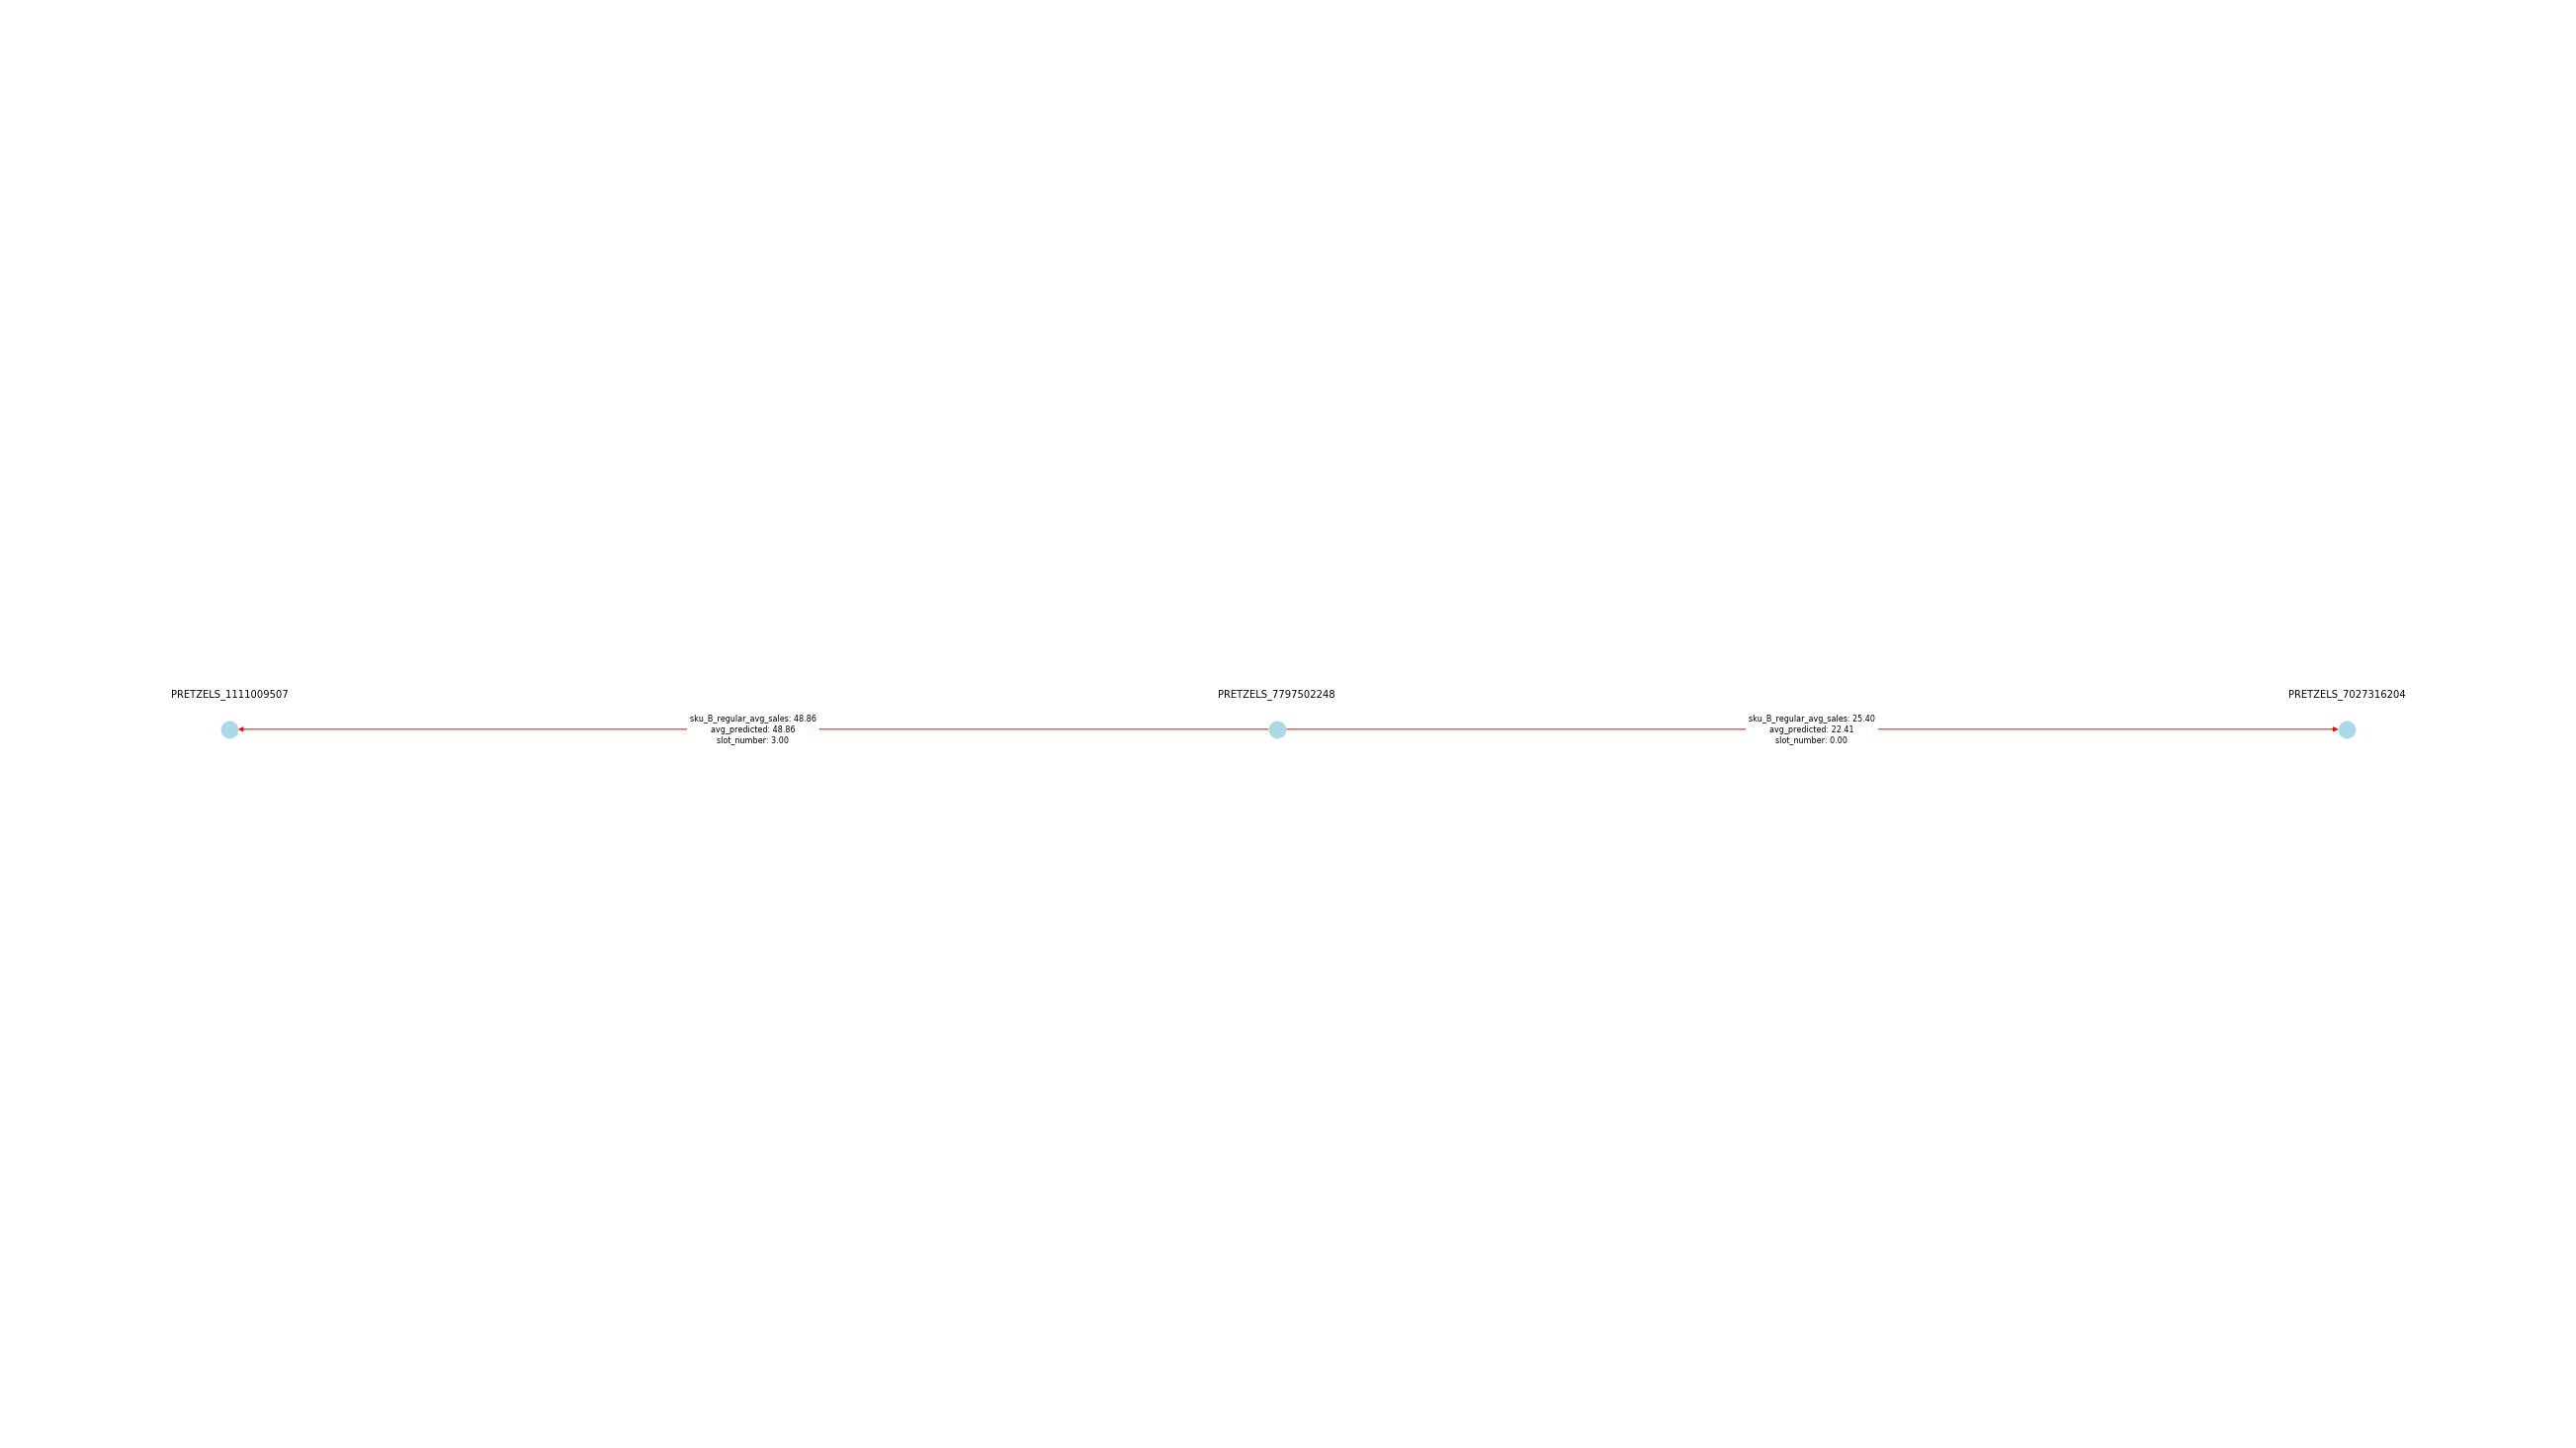

In [28]:
if save_all_cannibals:
    text_offset = 3e-4
    fig_h = 20
    fig_w = 36
    fig = plt.figure(figsize=(fig_w,fig_h))
    pos = nx.nx_agraph.graphviz_layout(DG, prog="sfdp")
    nx.draw(DG, pos, \
        node_color='lightblue', linewidths=0.5, font_size=10, \
        font_weight='bold', with_labels=False, edge_color='r')

    labels = nx.get_edge_attributes(DG, 'label')
    nx.draw_networkx_edge_labels(DG, pos, edge_labels=labels, font_size=8)

    for k, v in pos.items():
        plt.text(v[0],v[1]+text_offset, s=k, horizontalalignment='center')


    foldername = os.path.join(dataFolder, results_folder, category_id, dept_id, 'graphs')
    fhelp.makeFolder(foldername)
    plt_filename = os.path.join(foldername, f'cannibals-{store_name}.pdf')
    plt.savefig(plt_filename, format='pdf', dpi=300, bbox_inches='tight')
    
    # Save file for Gephi
    gph_filename = os.path.join(foldername, f'cannibals-{store_name}.gexf')
    nx.write_gexf(DG, gph_filename)
    
    # Save file for GraphViz
    dot_filename = os.path.join(foldername, f'cannibals-{store_name}.dot')
    print(f'Writing {dot_filename}...')
    from networkx.drawing.nx_agraph import write_dot
    write_dot(DG, dot_filename)